# Práctica 2 - CNNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

En esta práctica vamos a utilizar el dataset STL-10, que está diseñado para clasificación de imágenes. Vamos a ver que contiene 13,000 imágenes etiquetadas de tamaño 96×96 píxeles en color (RGB), y que estas se clasifican en 10 clases (avión, pájaro, coche, gato, ciervo, perro, caballo, mono, barco, camión). Además incluye 100,000 imágenes sin etiquetar para aprendizaje no supervisado, aunque no las vamos a utilizar. El objetivo es entrenar una red neuronal convolucional para clasificar estas imágenes.

Primero cargaremos y preprocesaremos los datos: normalizando las imágenes y convirtiendo las etiquetas a one-hot. A diferencia de la práctica anterior, no aplanaremos las imágenes, ya que queremos conservar su estructura bidimensional original para que la red pueda captar relaciones espaciales entre píxeles cercanos.

Luego, entrenaremos varios modelos aplicando distintas formas de regularización para analizar cómo afectan al rendimiento en validación y test.

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import visualkeras
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

En primer lugar importamos las librerías que vamos a utilizar a lo largo de la práctica.


In [17]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Fijamos una semilla aleatoria para asegurar que los experimentos sean reproducibles y así poder compararlos mejor. Sin ella, procesos como la inicialización de pesos o el shuffle de datos producirían resultados diferentes en cada ejecución, y no podríamos determinar si las diferencias de rendimiento se deben al azar.

### 1. Carga del dataset

In [18]:
# Cargamos el dataset STL-10 ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc.)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

Reutilizamos código de la práctrica anterior. Al tener que presentar las imágenes como un mapa bidimensional, eliminamos la línea conde las aplanamos y las mantenemos en su forma original.
Como antes teníamos las imágenes aplanadas, usábamos `np.array()` para pasarlo a numpy. Ahora como tenemos las dimansiones originales, tenemos que usar `tf.stack()`

In [19]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset:
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra
        # Añadimos los resultafos a las listas
        imagenes.append(imagen)
        etiquetas.append(etiqueta)

    # Convertimos a arrays de numpy (manteniendo las 3 dimensiones)
    return tf.stack(imagenes).numpy(), tf.stack(etiquetas).numpy()

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)


print("Shape de train_inputs:", train_inputs.shape)
print("Shape de train_targets:", train_targets.shape)

Shape de train_inputs: (5000, 96, 96, 3)
Shape de train_targets: (5000, 10)


- Las imágenes vienen en formato uint8 (enteros sin signo), con valores de píxeles  entre 0 y 255, por lo que **escalamos** los píxeles al rango [0, 1] dividiendo por 255 para que la red converja más rápido y de forma más estable.

- A diferencia de la P1, no se aplanan las imágenes. En este caso se mantienen con su estructura tridimensional original (96, 96, 3) para conservar la información espacial entre píxeles y poder aprovechar las operaciones de convolución que realiza la CNN.

- Usamos **one-hot encoding** cuando tenemos variables categóricas que no tiene sentido ordenar (no hay una categoría “mayor” o “menor” que la otra), como es nuestro caso con las 10 clases del dataset (avión, pájaro, coche, gato, etc.). Con esto convertimos una etiqueta categórica en un vector donde solo la posición correspondiente a esa categoría tiene un 1 y el resto son 0s (por ejemplo, la clase 0 se convierte en [1,0,0,0,0,0,0,0,0,0]). Si dejáramos las etiquetas como números del 0 al 9, podría interpretarse erróneamente que existe una relación de orden entre ellas.

####  División del dataset

In [20]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

Dividimos el conjunto de entrenamiento original en dos partes: **entrenamiento** (80%) y **validación** (20%), lo que queda en 4000 imágenes para entrenamiento y 1000 para validación. El conjunto de entrenamiento se usa para que el modelo aprenda ajustando sus pesos, mientras que el de validación sirve para evaluar su rendimiento durante el entrenamiento sin que el modelo vea esos datos en el proceso de aprendizaje. Lo vamos a usar para **detectar sobreajuste** (si la accuracy en entrenamiento sube pero en validación baja, el modelo está memorizando en lugar de generalizar).

Para la división del dataset, se mezclan las muestras del conjunto de entrenamiento, de manera que la separación entre entrenamiento y validación sea aleatoria. La división que hemos escogido permite evaluar correctamente el modelo sin reducir demasiado la cantidad de datos disponibles para entrenar.

El conjunto de test, por su parte, permanece completamente separado y solo se usa al final para evaluar el rendimiento real del modelo en datos nunca vistos.

### 3. Creación y entrenamiento de modelos convolucionales personalizados para el problema de clasificación

Reutilizamos esta función que desarrollamos en la P1 que incluye todo el proceso de entrenamiento y evaluación para evitar repetir código cada vez que entrenemos un modelo diferente.

In [21]:
def entrenar(modelo, train, val, test, epochs=15):

    # Desempaquetamos los conjuntos de datos
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test

    # Entrenamos el modelo
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128
    )

    # Evaluamos el modelo en test y mostramos resultados
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)

    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, loss, acc, prec, rec, f1

Utilizamos la división de training y validación para entrenar el modelo con los siguientes parámetros:

- **15 epochs** por defecto (cada epoch es una pasada completa por todos los datos de entrenamiento). Sin embargo, este parámetro lo ajustaremos después si es necesario en función del modelo. Con un número de epochs muy bajo este no aprende bien y si es muy alto puede haber mucho sobreajuste.

- **Batch_size de 128** para conseguir un punto medio entre ejecuciones rápidas y mejor estabilidad. Tras probar también con  32, 64 y 256, este fue el que nos dio mejores resultados.

- **Early Stopping** (opcional). Detiene automáticamente el entrenamiento cuando el modelo deja de mejorar. También podemos pasar distintos parámetros para configurarlo.
    - Por defecto monitorizamos el loss de validación con una paciencia de 3 epochs. Ambas cosas se pueden cambiar.
    - Lo configuramos para que restaure el modelo con los mejores pesos encontrados durante el entrenamiento, no el último.



Después del entrenamiento, evaluamos el rendimiento del modelo con el conjunto de test, usando las siguientes métricas:

- **Loss**: mide cómo de equivocado está el modelo (compara lo que predijo con lo que debería haber dicho).
- **Accuracy**: nos da el porcentaje total de aciertos. En nuestro caso las clases están balanceadas, por lo que es bastante fiable. Aun así, lo vamos a respaldar con las siguientes métricas.
- **Precision**: mide cuántas de las predicciones positivas del modelo son realmente correctas, evitando falsos positivos (de todas las veces que el modelo dijo "esto es un gato", ¿cuántas veces acertó?).
- **Recall**: evalúa falsos negativos (cuando no detecta algo que sí es)(de todos los gatos reales en el dataset, ¿cuántos detectó correctamente?).
- **F1-score**: combina precision y recall en una sola métrica y siempre es balanceado.

In [22]:
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Utilizamos la función **plot** para enseñar gráficamente como van cambiando trainig y test y detectar más fácilmente el overfitting. Está tomada del **Laboratorio 5 (Optimización)**, siendo la única diferencia que hemos hecho que las gráficas salgan una al lado de la otra y no una encima de la otra para que ocupen menos espacio.


#### 3.1. Modelo 1 - CNN base


In [ ]:
def cnn_base(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    cnn_base = models.Model(inputs, outputs, name="cnn_base")
    return cnn_base

cnn_base = cnn_base(tamano_imagen,num_clases)

cnn_base.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

cnn_base.summary()


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Empezamos con una red **convolucional base (CNN)**, diseñada para trabajar directamente con imágenes sin necesidad de aplanarlas desde el inicio. Su objetivo es que las capas iniciales detecten automáticamente patrones espaciales como bordes, texturas y formas, para que las capas posteriores puedan combinarlos en representaciones más complejas.

La arquitectura final que hemos utilizado es la siguiente:

- **Capa de entrada**: recibe imágenes de tamaño (96, 96, 3), es decir, de 96×96 píxeles y tres canales (RGB).

- **Bloques convolucionales**: se aplican varias capas *Conv2D* con filtros de tamaños crecientes (32, 64, 128 y dos de 256). Cada una utiliza un *kernel* de 3×3, activación *ReLU* y *padding="same"*, lo que permite mantener las dimensiones espaciales tras cada convolución.
  - Las primeras capas capturan rasgos simples (bordes, colores o texturas), mientras que las más profundas aprenden características más abstractas (formas o estructuras completas de los objetos).

- **Capas de *Pooling***: después de las convoluciones se alternan capas de *MaxPooling2D* y *AveragePooling2D* con tamaño 2×2, que reducen poco a poco la resolución de las imágenes y el número de parámetros. *MaxPooling* conserva las características más relevantes, mientras que *AveragePooling* suaviza la información para evitar excesivo sobreajuste.

- **Capa de aplanamiento (*Flatten*)**: transforma los mapas de características obtenidos por las capas convolucionales en un vector unidimensional para poder conectarlo con la capa de salida.

- **Capa de salida**: totalmente conectada (*Dense*) con tantas neuronas como clases (en este caso 10) y activación *softmax*, que genera una distribución de probabilidad entre las clases posibles.

Usamos el optimizador **Adam** con un learning rate inicial de 0.0003 para ajustar los pesos automáticamente durante el entrenamiento. Converge rápido y se utiliza mucho actualmente. Como función de **loss** para penalizar predicciones incorrectas, utilizamos *Categorical Crossentropy* al tratarse de una clasificación multiclase que además hemos puesto en forma one-hot.

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.1344 - f1_score: 0.0958 - loss: 2.2482 - precision: 0.2128 - recall: 0.0015 - val_accuracy: 0.2510 - val_f1_score: 0.1966 - val_loss: 2.0891 - val_precision: 0.4311 - val_recall: 0.0720
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3259 - f1_score: 0.2928 - loss: 1.8457 - precision: 0.6389 - recall: 0.0829 - val_accuracy: 0.3120 - val_f1_score: 0.2800 - val_loss: 1.8417 - val_precision: 0.5157 - val_recall: 0.1480
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4049 - f1_score: 0.3795 - loss: 1.6236 - precision: 0.6747 - recall: 0.1625 - val_accuracy: 0.3780 - val_f1_score: 0.3620 - val_loss: 1.6554 - val_precision: 0.5600 - val_recall: 0.1820
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4563 - f1_score: 0.4388 - loss: 1.4913 - precision: 0.6975 - recall: 0.2284 - val_accuracy: 0.4240 - val_f1_score: 0.4074 - val_loss: 1.5814 - val_precision: 0.5977 - val_recall: 0

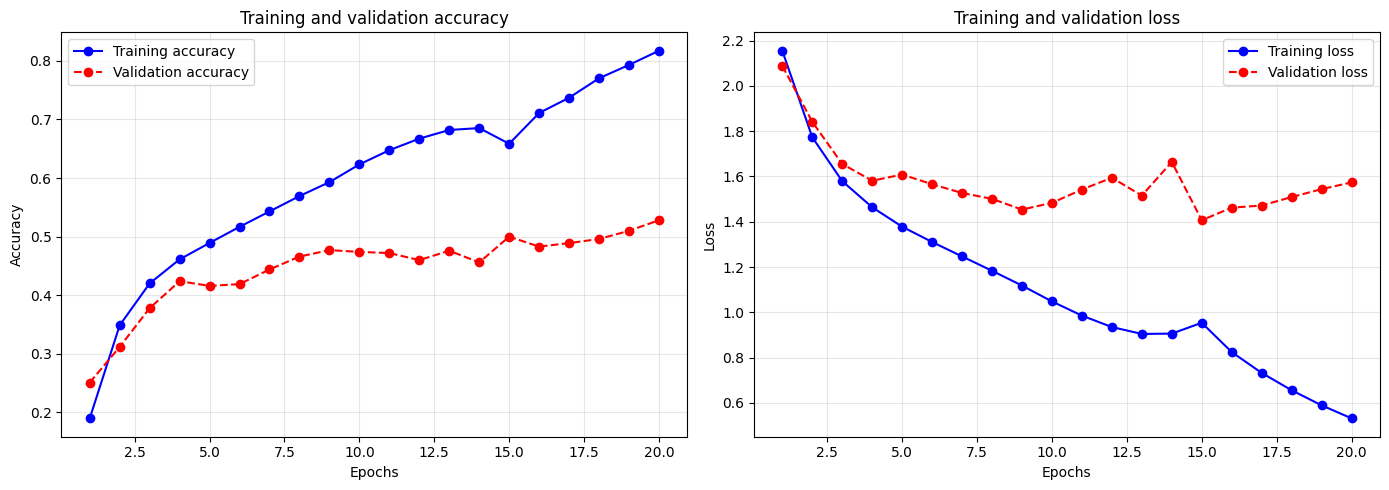

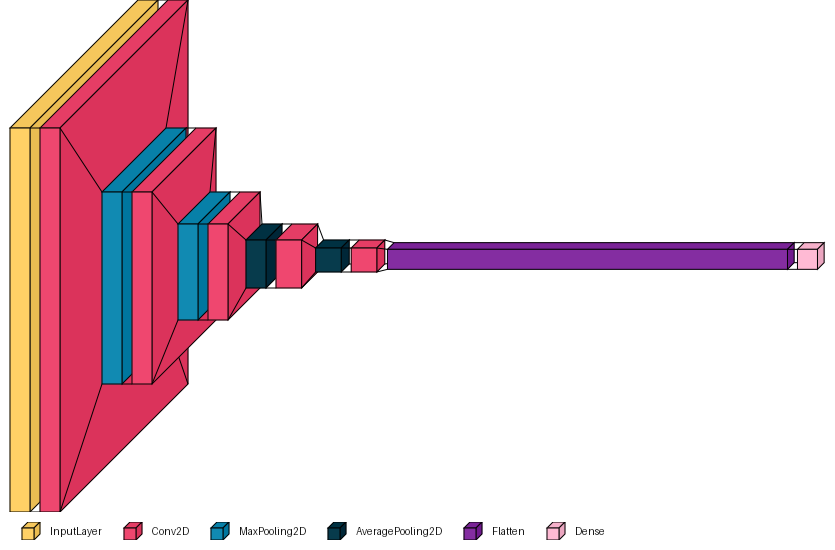

In [54]:
hist_base, loss_base, acc_base, prec_base, rec_base, f1_base= entrenar(
    cnn_base,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 20
)

plot(hist_base)
visualkeras.layered_view(cnn_base, legend=True)

Con estos resultados observamos que el modelo **aprende correctamente durante el entrenamiento**, pero empieza a mostrar síntomas de **sobreajuste**.
El *accuracy* de entrenamiento aumenta de forma constante desde un 13% hasta llegar al **80%**, mientras que la de validación se mantiene más baja, alrededor del **45–50%**, sin mejorar de forma notable tras las primeras épocas.
En la gráfica observamos que la pérdida de entrenamiento desciende de forma continua, mientras que la pérdida de validación deja de mejorar a mitad del proceso y se estabiliza.
Esto indica que la red está aprendiendo muy bien los ejemplos del conjunto de entrenamiento, pero le cuesta generalizar a imágenes nuevas. 

Los resultados finales en test confirman esta tendencia:

- El **accuracy de 55.16%** indica que el modelo acierta algo más de la mitad de las imágenes, demostrando que ha aprendido patrones útiles, aunque todavía se equivoca.
- El **precision de 62.38%** significa que cuando predice una clase, acierta en torno a 6 de cada 10 veces, lo que indica que sus predicciones suelen ser fiables.
- Un **recall de 48.79%** significa que detecta correctamente casi la mitad de los ejemplos reales de cada clase, lo que sugiere que aún deja escapar bastantes casos correctos.
- Esta combinación de precision y recall resulta en un **F1-score de 0.55**.
- El **Loss de 1.47** mantiene un valor moderado y relativamente cercano al observado en validación, lo que indica una generalización aceptable.

#### Aplicación de técnicas de regularización

A partir del modelo base, hemos probado algunas técnicas de regularización para reducir el overfitting y mejorar la capacidad de generalización de la red:

lo hacemos luego cuando esté todo lmao


#### 3.2 Modelo 2 - Data augmentation

In [24]:
# esto lo cogí del lab 6, pone en el enunciado que hagamos aumento de datos. esto lo aplica luego al ppo del modelo, despés del input
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

data_aug = data_aug(tamano_imagen,num_clases)

data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_28            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_29            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Aquí añadimos **Data Augmentation** justo **desués de la entrada** para que cada imagen de entrenamiento se transforme **de forma aleatoria en cada epoch**, permitiendo que el modelo vea versiones diferentes de las mismas imágenes y así reduzca el sobreajuste sin modificar el conjunto de validación ni el de test.

**Bloque de aumento de datos usado:**

- **RandomFlip("horizontal"):** Invierte la imagen izquierda-derecha aleatoriamente. En STL-10 (avión, coche, perro, etc.) un giro horizontal mantiene el significado visual y añade vistas simétricas útiles. *Evitamos el vertical flip* porque generaría escenas poco realistas (barcos/aviones “boca abajo”).
- **RandomRotation(0.1):** Introduce pequeñas rotaciones para hacer el modelo robusto a leves desalineaciones propias de la captura. Un rango corto evita deformaciones fuertes que cambien la clase.
- **RandomZoom(0.2):** Simula cambios de escala/distancia a cámara. Ayuda a que los filtros aprendan patrones que se reconocen tanto de cerca como de lejos.

**Por qué estos valores:**

- Son transformaciones **geométricas suaves** que **conservan la clase** y respetan la composición típica del dataset.
- El rango es **moderado** (10–20%) para no introducir cambios ni recortes excesivos en imágenes de **96×96 píxeles**, donde el detalle es limitado.
  - Evitamos transformaciones agresivas (rotaciones grandes, recortes fuertes, vertical flip) para no degradar la semántica.

**Por qué en esa posición del modelo:** Se aplica **antes de las convoluciones**, sobre los **tensores de entrada**, para que todas las capas vean datos variados desde el inicio.

Lo que buscamos con esto es hacer al modelo **invariante** a pequeñas rotaciones, espejos y cambios de escala; y **reducir la memorización** de detalles específicos del conjunto de entrenamiento.

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1402 - f1_score: 0.0879 - loss: 2.2514 - precision: 0.2089 - recall: 0.0010 - val_accuracy: 0.2440 - val_f1_score: 0.2023 - val_loss: 1.9912 - val_precision: 0.4490 - val_recall: 0.0220
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2940 - f1_score: 0.2515 - loss: 1.9291 - precision: 0.6038 - recall: 0.0361 - val_accuracy: 0.2870 - val_f1_score: 0.2507 - val_loss: 1.9004 - val_precision: 0.5806 - val_recall: 0.0900
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3690 - f1_score: 0.3380 - loss: 1.7712 - precision: 0.7129 - recall: 0.0810 - val_accuracy: 0.3110 - val_f1_score: 0.2748 - val_loss: 2.0705 - val_precision: 0.4232 - val_recall: 0.1680
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3947 - f1_score: 0.3671 - loss: 1.6859 - precision: 0.6712 - recall: 0.1386 - val_accuracy: 0.3420 - val_f1_score: 0.3026 - val_loss: 2.0214 - val_precision: 0.4941 - val_recall: 0.2

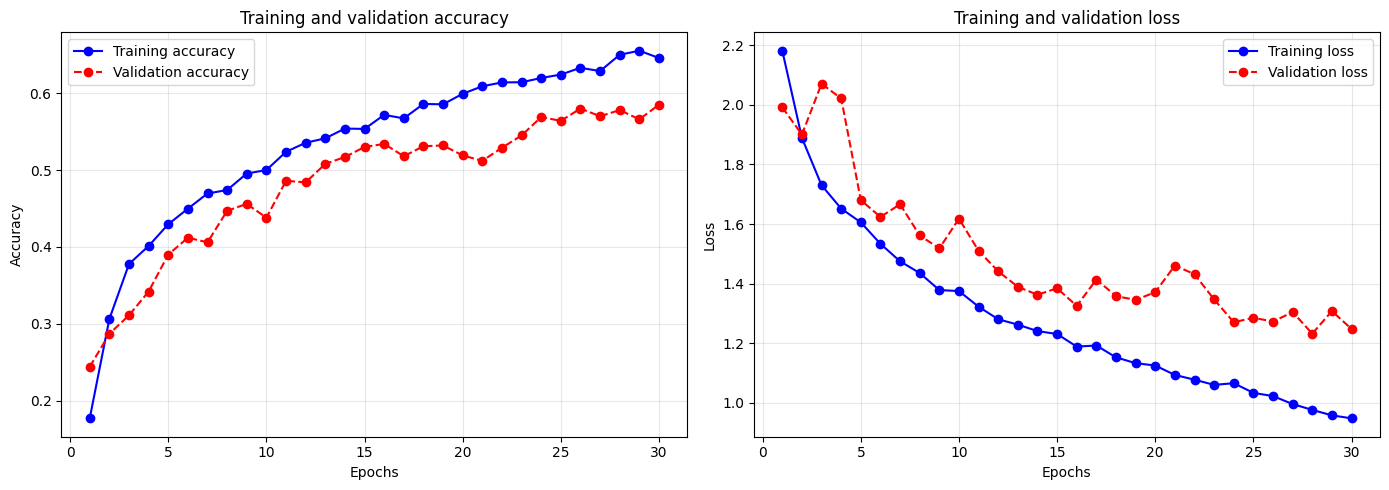

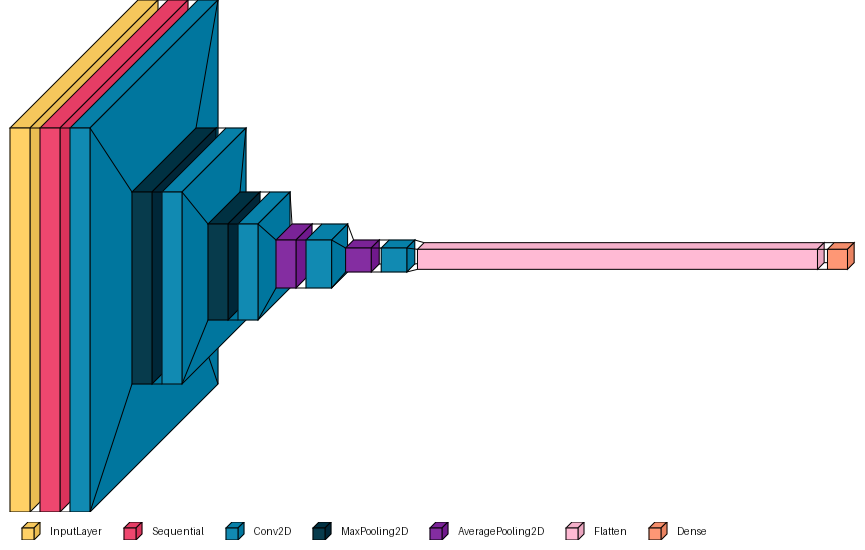

In [76]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 30
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

Con estos resultados, vemos que el **Data Augmentation ha mejorado la generalización del modelo** respecto al CNN base.
Durante el entrenamiento, el *accuracy* en los datos de entrenamiento asciende de forma progresiva hasta el **65%** más o menos, mientras que la *validation accuracy* alcanza un **58%**, manteniéndose más cercana a la curva de entrenamiento que en el modelo base.
En la gráfica de *loss* también se aprecia una mejora: tanto *training loss* como *validation loss* descienden de forma estable y convergen alrededor de **1.0–1.2**, sin la divergencia que mostraba el modelo base.

Esto indica que el modelo no solo está aprendiendo mejor, sino que además **ha reducido  el sobreajuste** gracias al aumento de datos. Las transformaciones aleatorias han ayudado a que el modelo vea más variedad de ejemplos y no memorice patrones concretos del conjunto de entrenamiento.

Los resultados finales en **test** lo confirman:

* El **accuracy de 59.15%** supone una **mejora de casi 4 puntos** respecto al CNN base que tenía un 55%, mostrando que el modelo generaliza mejor ante datos nuevos.
* La **precision de 68.21%** indica que el modelo acierta con mayor fiabilidad cuando realiza una predicción, lo que sugiere decisiones más seguras.
* El **recall del 50.99%** significa quw detecta correctamente más de la mitad de los ejemplos reales de cada clase, mejorando también frente al modelo base.
* El **loss de 1.21** desciende respecto al modelo base (1.47), indicando que el aprendizaje ha sido más efectivo y estable.

Con esto, podemos decir que el **modelo con Data Augmentation ha reducido el sobreajuste y mejorado la capacidad de generalización** del modelo base.


#### 3.3 Modelo 3 - Dropout

In [ ]:
def dropout(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)  

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)  

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)  

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Dropout(0.4)(x)  

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)

    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    dropout = models.Model(inputs, outputs, name="dropout")
    return dropout

dropout = dropout(tamano_imagen, num_clases)

dropout.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ]
)

dropout.summary()


Model: "dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Hemos añadido **Dropout** en varias capas del modelo CNN base para intentar reducir el **sobreajuste** y mejorar la capacidad de generalización.
La arquitectura base se mantiene, pero ahora incorporamos diferentes tasas de desactivación de neuronas después de cada bloque convolucional:

* **Dropout 0.1** tras el primer bloque (**Conv2D 32 filtros + MaxPooling2D**): En las primeras capas la red aprende patrones muy básicos (bordes, colores, texturas), por lo que conviene usar una tasa baja. Así evitamos eliminar demasiada información relevante al inicio del procesamiento.

* **Dropout 0.2** tras el segundo bloque (**Conv2D 64 filtros**): En esta etapa el modelo empieza a combinar rasgos simples para detectar formas más definidas. Aumentamos un poco el dropout para reducir la redundancia y prevenir que memorice ejemplos concretos.

* **Dropout 0.3** tras el tercer bloque (**Conv2D 128 filtros**): Aquí ya se manejan características más abstractas. Incrementamos la tasa para forzar al modelo a no depender de combinaciones fijas de neuronas y favorecer una representación más robusta.

* **Dropout 0.4** tras el cuarto bloque (**Conv2D 256 filtros**): En las capas más profundas hay más riesgo de sobreajuste, así que aplicamos un dropout alto para mejorar la generalización.

* **Dropout 0.5** antes de la capa densa final: Esta es la capa más crítica, ya que conecta toda la información previa con la decisión final. Desactivar aleatoriamente la mitad de las neuronas evita que el modelo confíe en rutas específicas y le obliga a aprender representaciones distribuidas.

**Por qué estos valores:** Probamos tasas más altas en las primeras capas (0.3–0.4) pero redujeron el rendimiento, ya que eliminaban información fundamental. En cambio, esta progresión gradual de 0.1 a 0.5 consiguió equilibrar bien el aprendizaje, teniendo menos pérdida de detalle al inicio y mayor regularización al final.

**Por qué en esas posiciones:**: Colocamos *Dropout* tras cada bloque convolucional, nunca antes, para actuar justo después de la extracción de características. Además, evitamos usarlo dentro de los *poolings* o entre convoluciones consecutivas para no interrumpir la coherencia espacial.

Con este modelo buscamos **reducir la brecha entre entrenamiento y validación**, estabilizar las curvas de *val_loss* y *val_accuracy*, y lograr una red más resistente al sobreajuste sin comprometer su capacidad para detectar patrones visuales complejos.


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 471ms/step - accuracy: 0.1435 - f1_score: 0.1133 - loss: 2.2629 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2100 - val_f1_score: 0.1636 - val_loss: 2.1380 - val_precision: 0.4545 - val_recall: 0.0150
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2880 - f1_score: 0.2735 - loss: 1.9565 - precision: 0.6309 - recall: 0.0470 - val_accuracy: 0.3040 - val_f1_score: 0.2818 - val_loss: 1.8942 - val_precision: 0.5921 - val_recall: 0.0900
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.3413 - f1_score: 0.3223 - loss: 1.7725 - precision: 0.6687 - recall: 0.1090 - val_accuracy: 0.3420 - val_f1_score: 0.3210 - val_loss: 1.7169 - val_precision: 0.6319 - val_recall: 0.1030
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.3983 - f1_score: 0.3842 - loss: 1.6249 - precision: 0.6701 - recall: 0.1615 - val_accuracy: 0.3710 - val_f1_score: 0.3601 - val_loss: 1.6156 - val_precision: 0.6425 -

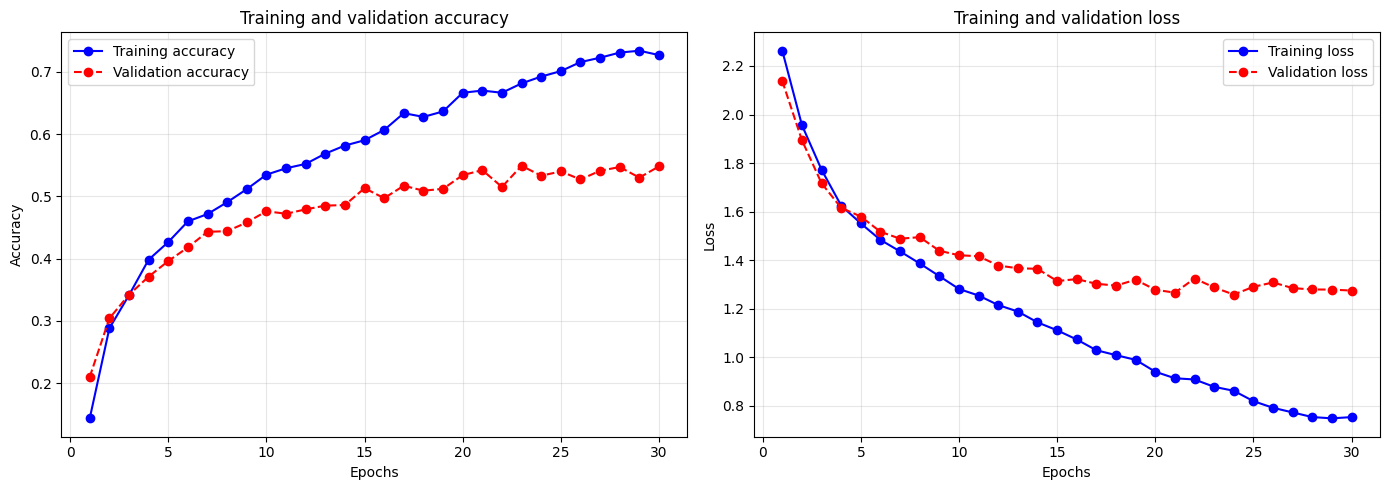

c:\Users\NataliaUDC\anaconda3\envs\AP-311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


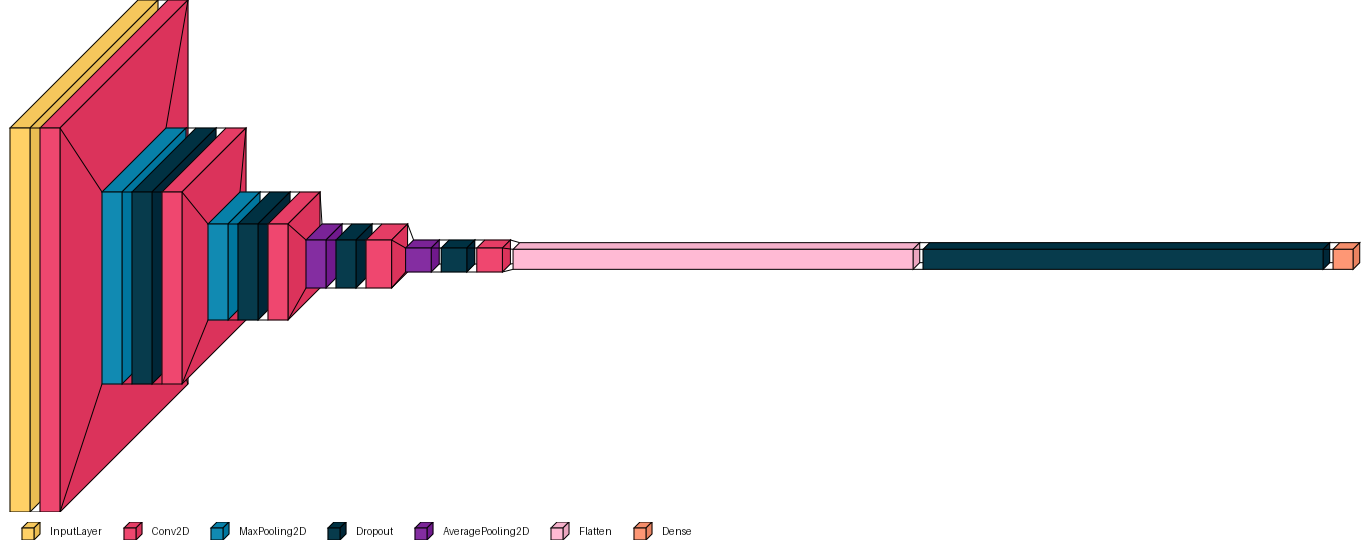

In [16]:
hist_dropout, loss_dropout, acc_dropout, prec_dropout, rec_dropout, f1_dropout= entrenar(
    dropout,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 30
)

plot(hist_dropout)
visualkeras.layered_view(dropout, legend=True)

Con estos resultados, observamos que el **Dropout ha mejorado la estabilidad del entrenamiento y ha reducido un poco el sobreajuste**.
En las gráficas se aprecia que el *accuracy* de entrenamiento aumenta progresivamente hasta alrededor del **70%**, mientras que la de validación se mantiene más baja, en torno al **50%**, sin grandes oscilaciones. Esto indica que el modelo aprende de manera controlada y sin sobreajustar tan rápido como ocurría con el modelo base.

El *loss* de entrenamiento desciende de forma continua hasta valores cercanos a **0.8**, mientras que el *loss* de validación se estabiliza alrededor de **1.5**, sin mostrar un incremento al final del proceso. Esta evolución más suave sugiere que el modelo consigue generalizar mejor y que la regularización mediante *Dropout* está funcionando como se esperaba.

Los resultados en **test** refuerzan esta idea:

* **Accuracy: 58.51%**, ligeramente superior al 55.16% del modelo base, lo que muestra una mejora real en la capacidad de generalización.
* **Precision: 69.68%**, que indica que, cuando el modelo predice una clase, acierta casi 7 de cada 10 veces.
* **Recall: 47.49%**, algo inferior al de precisión, lo que significa que todavía se le escapan algunos ejemplos correctos, pero mantiene un equilibrio razonable.
* **F1-score: 0.58**, el mejor resultado hasta ahora, reflejando un avance tanto en precisión como en cobertura.
* **Loss: 1.18**, más bajo que el 1.47 del modelo base, lo que confirma una mejora en la generalización del modelo.

En conjunto, el modelo con Dropout logra **mejores resultados de test**, **curvas de validación más estables** y una **menor diferencia entre entrenamiento y validación**. Aunque todavía se observa algo de sobreajuste, este es mucho menor que antes. El uso progresivo de tasas de Dropout (del 0.1 al 0.5) ha permitido equilibrar el aprendizaje, manteniendo la capacidad de la red para detectar patrones complejos mientras reduce su tendencia a memorizar los datos del conjunto de entrenamiento.


#### 3.4 Modelo 4 - L2

Probé tb con 1e-3 y 1e-4 pero penalizaban demasiado los pesos y el modelo aprendía peor. Con 5e-5 funcionó mejor xq mantuvo el equilibrio. osea no sobreajustó y consiguió mejores resultados en accuracy y F1-score.

In [ ]:
def L2(input_shape, num_classes):
    l2_reg = regularizers.l2(5e-5)  # valor típico, puedes probar 1e-3 o 5e-4

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same",
                      kernel_regularizer=l2_reg)(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same",
                      kernel_regularizer=l2_reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same",
                      kernel_regularizer=l2_reg)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, kernel_size=3, activation="relu", padding="same",
                      kernel_regularizer=l2_reg)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, kernel_size=3, activation="relu", padding="same",
                      kernel_regularizer=l2_reg)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax",
                           kernel_regularizer=l2_reg)(x)

    L2 = models.Model(inputs, outputs, name="L2")
    return L2

L2 = L2(tamano_imagen, num_clases)

L2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ]
)

L2.summary()

Model: "L2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Hemos aplicado **regularización L2** en todas las capas convolucionales y en la capa densa final con el objetivo de **reducir el sobreajuste** que observamos en el modelo base.

La arquitectura general es la misma que la del modelo cnn_base, pero cada capa ahora incluye el término `kernel_regularizer=l2(5e-5)`. Esto significa que durante el entrenamiento se penalizan los pesos demasiado grandes, obligando a la red a mantenerlos más pequeños y estables. De este modo, el modelo tiende a generalizar mejor en datos nuevos en lugar de memorizar el conjunto de entrenamiento.

**Por qué este valor:** Probamos con tres intensidades de regularización (1e-3, 1e-4 y 5e-5). Los valores más altos (1e-3 y 1e-4) hacían que el modelo aprendiese más despacio y obtuviera peores métricas, ya que la penalización era demasiado fuerte y limitaba la capacidad de la red para ajustar los pesos. El valor **5e-5** resultó ser el más equilibrado, siendo este suficientemente bajo para no frenar el aprendizaje, pero efectivo para estabilizar las curvas de validación y reducir el gap entre entrenamiento y validación.

**Por qué en todas las capas:** se aplicó L2 en todas las capas porque su efecto consiste en **penalizar los pesos excesivos** y mantenerlos dentro de un rango estable durante el entrenamiento. Al hacerlo de forma uniforme en toda la red, cada nivel aprende a partir de restricciones similares, evitando que unas partes del modelo se ajusten más de lo necesario y otras menos.


Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - accuracy: 0.2000 - f1_score: 0.1769 - loss: 2.1698 - precision: 0.6567 - recall: 0.0110 - val_accuracy: 0.2440 - val_f1_score: 0.1815 - val_loss: 2.0513 - val_precision: 0.4800 - val_recall: 0.0960
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.3475 - f1_score: 0.3274 - loss: 1.7846 - precision: 0.6783 - recall: 0.0970 - val_accuracy: 0.3160 - val_f1_score: 0.2808 - val_loss: 1.8748 - val_precision: 0.4834 - val_recall: 0.1460
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.4157 - f1_score: 0.3992 - loss: 1.6028 - precision: 0.6773 - recall: 0.1653 - val_accuracy: 0.3840 - val_f1_score: 0.3632 - val_loss: 1.6958 - val_precision: 0.5637 - val_recall: 0.1770
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.4582 - f1_score: 0.4477 - loss: 1.4913 - precision: 0.7087 - recall: 0.2177 - val_accuracy: 0.4200 - val_f1_score: 0.4055 - val_loss: 1.5714 - val_precision: 0.6149 - val_rec

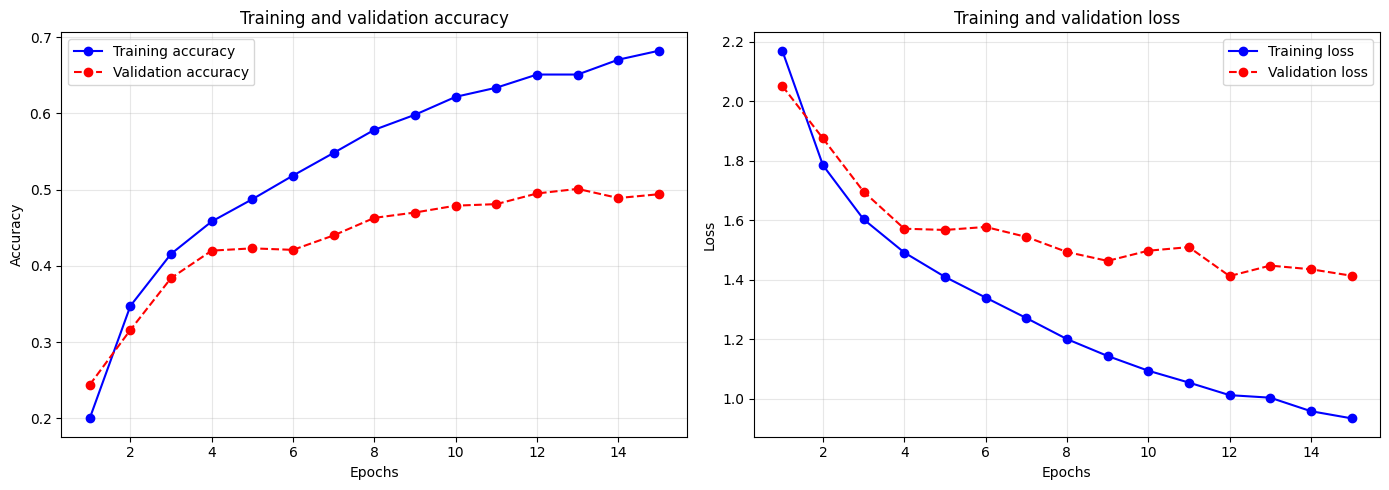

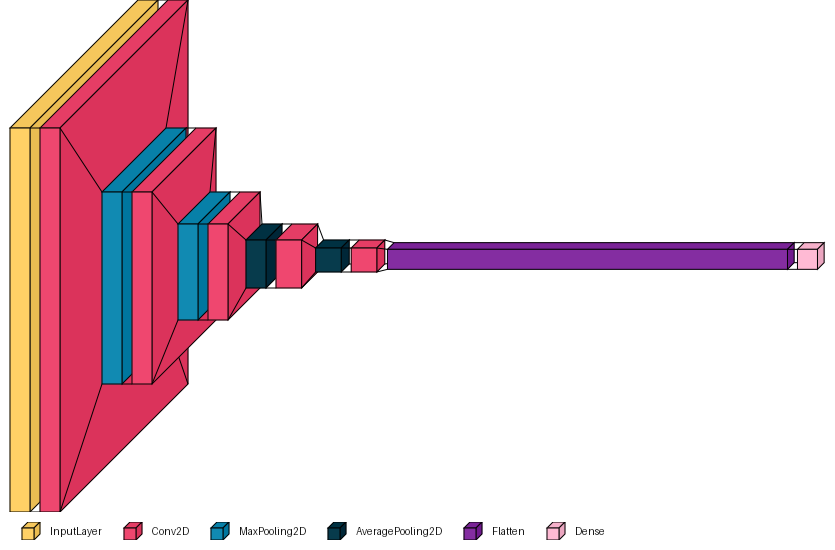

In [25]:
hist_L2, loss_L2, acc_L2, prec_L2, rec_L2, f1_L2 = entrenar(
    L2,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_L2)
visualkeras.layered_view(L2, legend=True)


Con estos resultados, observamos que la **regularización L2 consigue reducir un poco el sobreajuste** respecto al modelo base, manteniendo una evolución más equilibrada entre entrenamiento y validación.

Durante el entrenamiento, el *accuracy* aumenta de forma progresiva desde un 20% hasta alrededor del **68%** en el epoch 15, mientras que el de validación también mejora de manera estable hasta alcanzar un **49–50%**, sin estancarse bruscamente como ocurría en el modelo base.
En las gráficas se aprecia una **diferencia más moderada** entre las curvas de entrenamiento y validación: el *loss* de entrenamiento baja de 2.1 a **0.93**, y el de validación desciende hasta estabilizarse en torno a **1.4**, manteniendo una separación constante pero razonable.

Esto indica que el modelo sigue aprendiendo patrones relevantes sin memorizar en exceso los datos de entrenamiento. 

Los resultados en **test** confirman esta mejora en la generalización:

* El **accuracy de 54.24%** muestra un rendimiento muy similar al del modelo base (55.16%), pero con una evolución más regular y un entrenamiento más equilibrado.
* La **precision de 67.62%** indica que las predicciones del modelo son bastante fiables: cuando clasifica una imagen en una categoría, acierta aproximadamente dos tercios de las veces.
* El **recall de 41.93%** es algo más bajo, lo que significa que aún se escapan algunos casos reales, pero mantiene una relación coherente con el aumento de precisión.
* El **F1-score de 0.53** refleja un **rendimiento global sólido y estable**, en línea con los mejores valores alcanzados en validación.
* Por último, el **loss de 1.33** en test se mantiene próximo al de validación, lo que indica un buen equilibrio entre ajuste y generalización.

En conjunto, el modelo con **regularización L2** consigue un aprendizaje más controlado y menos propenso al sobreajuste. Aunque las métricas finales son similares a las del modelo base, su comportamiento durante el entrenamiento es **más estable y predecible**, lo que sugiere una **mejor capacidad de generalización**.


#### 3.5 OTRAS PRUEBAS

Probé tb con batch normalization pero fue una mierda, el modelo aprendió demasiado raápido. pasaba casi lo mismo q en la práctica anterior q las lineas estaban super separadas pero un poco menos esta vez. 

In [ ]:
# DATA AUG + DROPOUT
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

data_aug = data_aug(tamano_imagen,num_clases)

data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_35            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_36            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1231 - f1_score: 0.0808 - loss: 2.2663 - precision: 0.1372 - recall: 6.8739e-04 - val_accuracy: 0.1940 - val_f1_score: 0.1317 - val_loss: 2.1092 - val_precision: 0.5294 - val_recall: 0.0450
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2886 - f1_score: 0.2585 - loss: 1.9388 - precision: 0.6212 - recall: 0.0474 - val_accuracy: 0.2620 - val_f1_score: 0.2283 - val_loss: 2.0918 - val_precision: 0.3667 - val_recall: 0.1210
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3444 - f1_score: 0.3108 - loss: 1.7820 - precision: 0.6225 - recall: 0.0987 - val_accuracy: 0.3160 - val_f1_score: 0.2926 - val_loss: 2.0023 - val_precision: 0.4328 - val_recall: 0.1610
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3911 - f1_score: 0.3626 - loss: 1.6990 - precision: 0.6613 - recall: 0.1408 - val_accuracy: 0.3400 - val_f1_score: 0.3162 - val_loss: 1.8664 - val_precision: 0.4812 - val_recall:

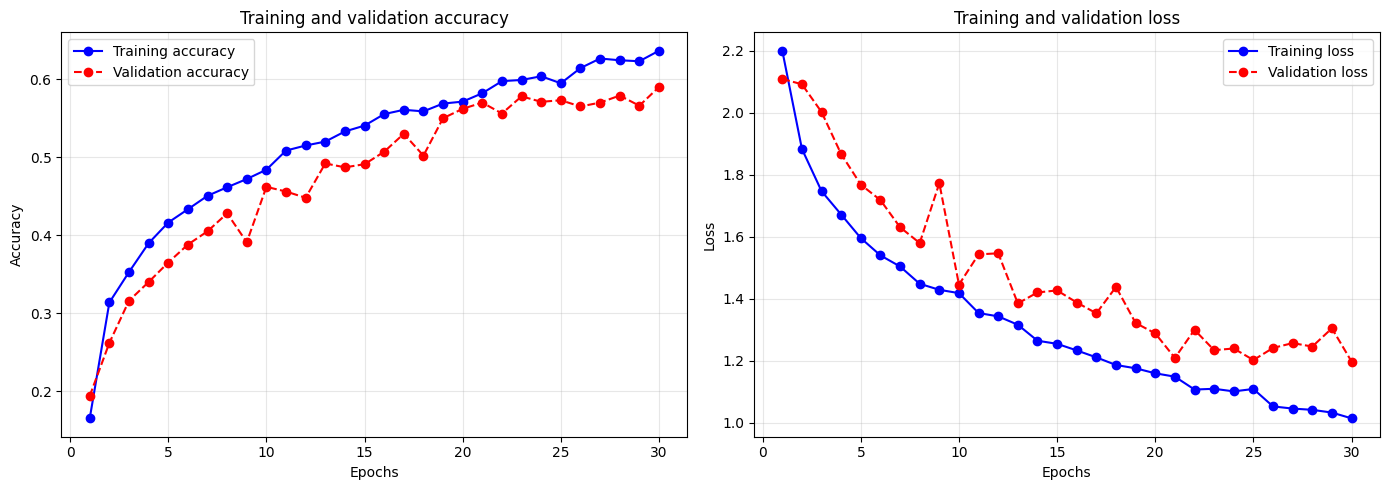

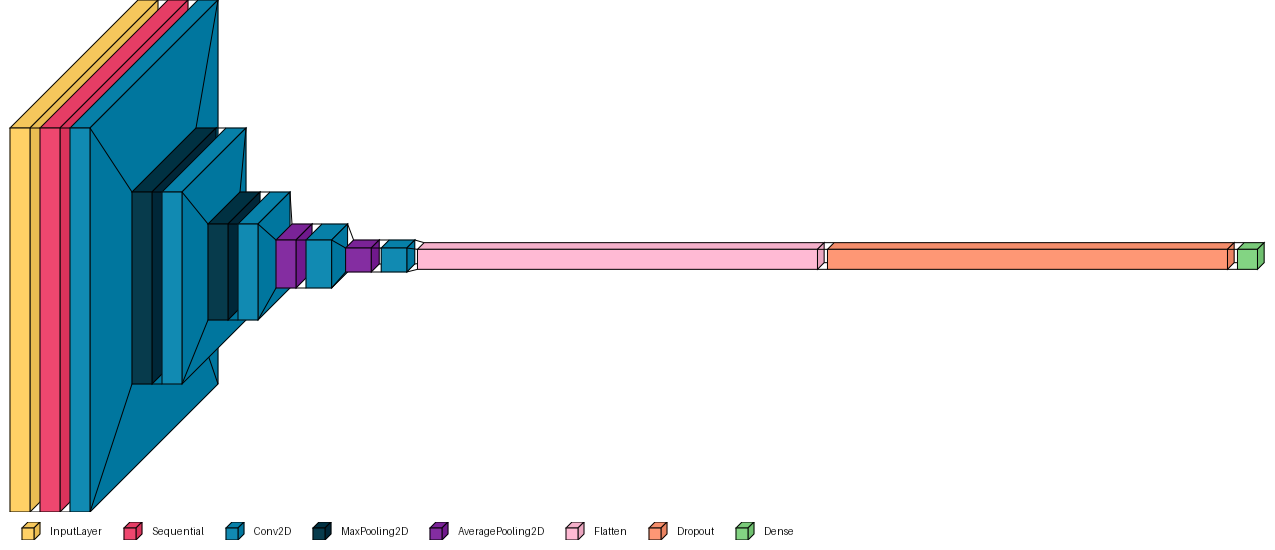

In [86]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 30
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

In [ ]:
# cAÑADI ALGUNOS EPOCHS PORQUE PARECIA QUE SEGUIA APRENDIENDO PERO AHORA EMPEORA UN PCO PERO NS
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)   

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

data_aug = data_aug(tamano_imagen,num_clases)

data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_43            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_44            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1265 - f1_score: 0.0878 - loss: 2.2714 - precision: 0.1858 - recall: 9.1635e-04 - val_accuracy: 0.2190 - val_f1_score: 0.1670 - val_loss: 2.1168 - val_precision: 0.5128 - val_recall: 0.0600
Epoch 2/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2834 - f1_score: 0.2545 - loss: 1.9618 - precision: 0.6431 - recall: 0.0557 - val_accuracy: 0.2340 - val_f1_score: 0.1999 - val_loss: 2.2677 - val_precision: 0.3740 - val_recall: 0.1380
Epoch 3/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3340 - f1_score: 0.3032 - loss: 1.8168 - precision: 0.6227 - recall: 0.0929 - val_accuracy: 0.3080 - val_f1_score: 0.2751 - val_loss: 2.0115 - val_precision: 0.4441 - val_recall: 0.1590
Epoch 4/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3767 - f1_score: 0.3540 - loss: 1.7053 - precision: 0.6564 - recall: 0.1452 - val_accuracy: 0.3340 - val_f1_score: 0.3091 - val_loss: 1.8572 - val_precision: 0.4910 - val_recall:

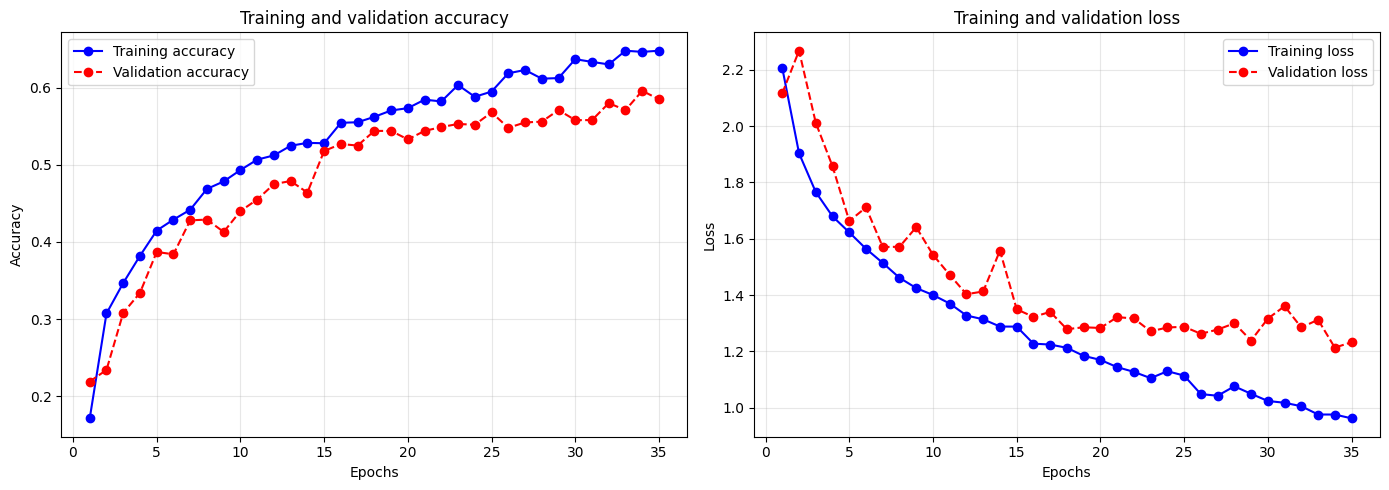

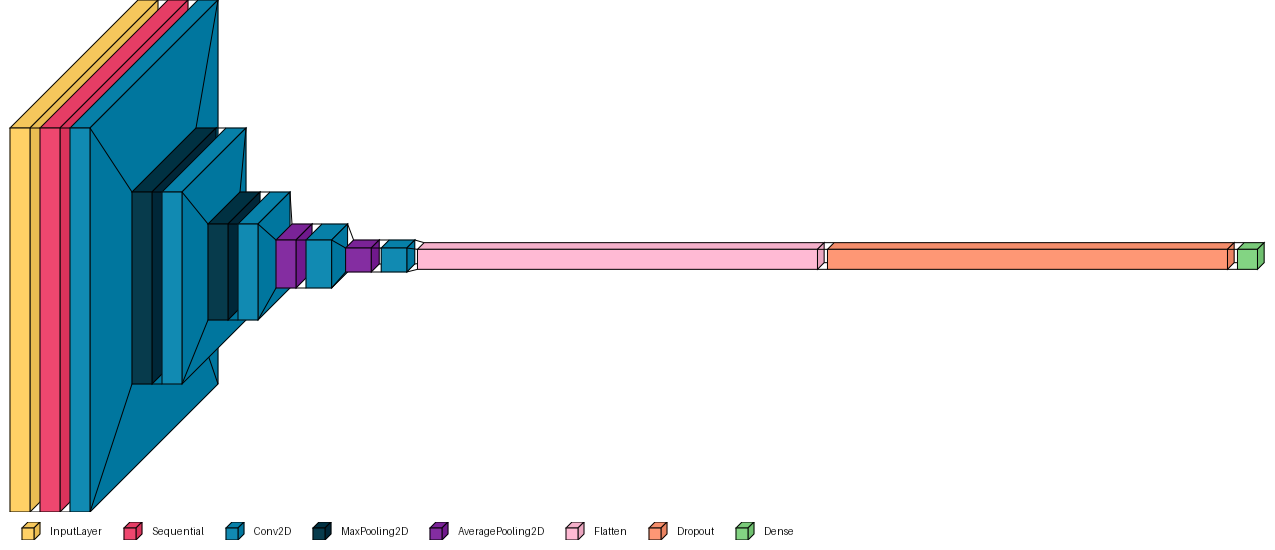

In [94]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 35
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

In [99]:
# ESTO LO PUSE PARA PROBAR EARLY STOPPING PERO CREO Q NO MERECE LA PENA USARLO
def entrenar(modelo, train, val, test, epochs=15, use_early_stopping=False,
             es_monitor='val_loss', es_patience=3, es_mode='min'):
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test

    callbacks = None
    if use_early_stopping:
        callbacks = [EarlyStopping(
            monitor=es_monitor,
            patience=es_patience,
            mode=es_mode,
            restore_best_weights=True,
            verbose=1
        )]


    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks
    )

    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)

    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, loss, acc, prec, rec, f1

In [104]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_49            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_50            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1257 - f1_score: 0.0832 - loss: 2.2674 - precision: 0.1738 - recall: 6.8730e-04 - val_accuracy: 0.1910 - val_f1_score: 0.1237 - val_loss: 2.1607 - val_precision: 0.4679 - val_recall: 0.0510
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2798 - f1_score: 0.2416 - loss: 1.9575 - precision: 0.6018 - recall: 0.0405 - val_accuracy: 0.2830 - val_f1_score: 0.2558 - val_loss: 2.0103 - val_precision: 0.4420 - val_recall: 0.1410
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3600 - f1_score: 0.3318 - loss: 1.7433 - precision: 0.6520 - recall: 0.1231 - val_accuracy: 0.3120 - val_f1_score: 0.2869 - val_loss: 1.9485 - val_precision: 0.4935 - val_recall: 0.1510
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3933 - f1_score: 0.3713 - loss: 1.6933 - precision: 0.6707 - recall: 0.1300 - val_accuracy: 0.3490 - val_f1_score: 0.3300 - val_loss: 1.9381 - val_precision: 0.4787 - val_recall:

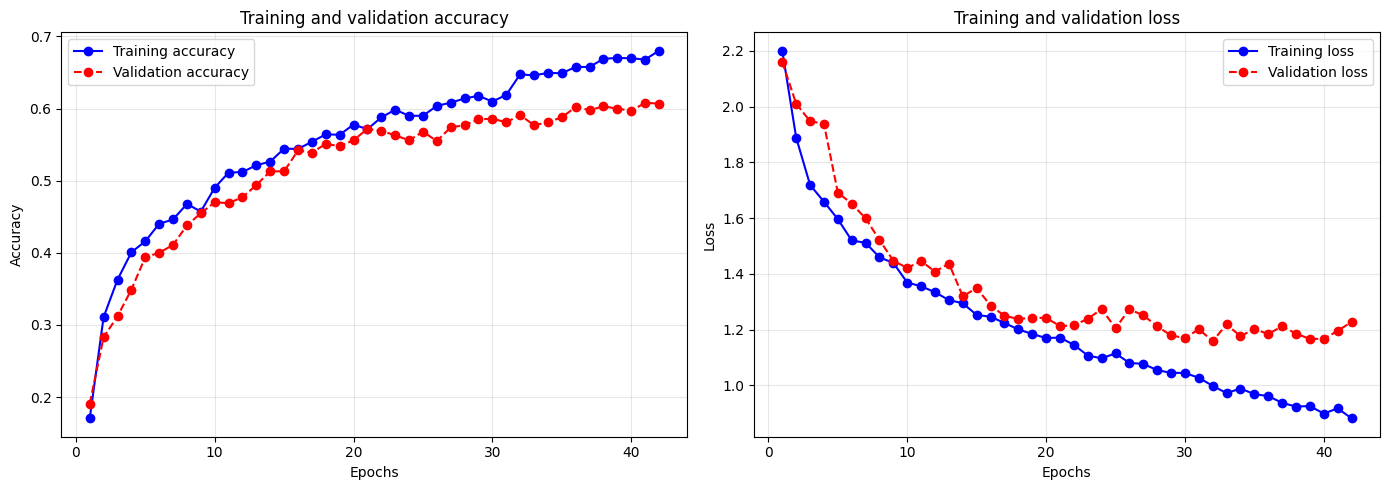

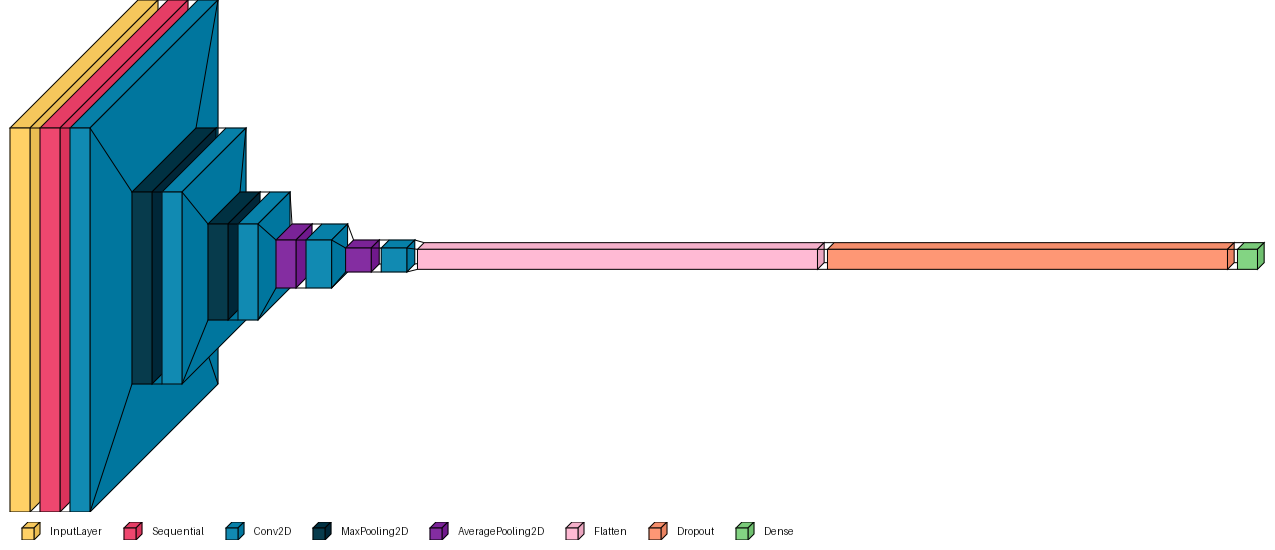

In [105]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 50,
    use_early_stopping = True, es_patience = 10
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

### Comparación de resultados

In [ ]:
import pandas as pd

# Creamos la tabla con los resultados obtenidos
results = pd.DataFrame({
    "Modelo": ["Vanilla","Con Dropout","Con Early Stopping", "Con L1","Con L2 ","Híbrido"],
    "Accuracy": [acc_base * 100,acc_data_aug* 100, acc_dropout*100, cc_L2 * 100],
    "Precision": [prec_base,prec_data_aug,prec_dropout, rec_L2],
    "Recall": [rec_base,rec_data_aug,rec_dropout, rec_L2],
    "F1-Score": [f1_base,f1_data_aug,f1_dropout,f1_L2],
    "Loss": [loss_base,loss_data_aug,loss_dropout,loss_L2]
})

results = results.round({"Accuracy": 3,"Precision": 3,"Recall": 3,"F1-Score": 3})

# Mostramos la tabla ordenada por Accuracy descendente
results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

### 4. Uso de una CNN preentrenada para el problema de clasificación

#### 4.1 Modelo 1 - Mobilenetv2 con Feature Extraction 

Model: "mobilenetv2_mejorado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preproc (Lambda)                │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.2421 - f1_score: 0.2367 - loss: 2.3959 - precision: 0.3493 - recall: 0.0928 - val_accuracy: 0.7650 - val_f1_score: 0.7663 - val_loss: 0.9372 - val_precision: 0.8964 - val_recall: 0.4930
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.7442 - f1_score: 0.7409 - loss: 0.8824 - precision: 0.8755 - recall: 0.5601 - val_accuracy: 0.8630 - val_f1_score: 0.8662 - val_loss: 0.5048 - val_precision: 0.9173 - val_recall: 0.7880
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.8687 - f1_score: 0.8678 - loss: 0.4779 - precision: 0.9194 - recall: 0.7994 - val_accuracy: 0.8910 - val_f1_score: 0.8932 - val_loss: 0.3870 - val_precision: 0.9311 - val_recall: 0.8510
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.9024 - f1_score: 0.9015 - loss: 0.3531 - precision: 0.9353 - recall: 0.8620 - val_accuracy: 0.9100 - val_f1_score: 0.9116 - val_loss: 0.3302 - val_precision: 0.9378 - val_recall:

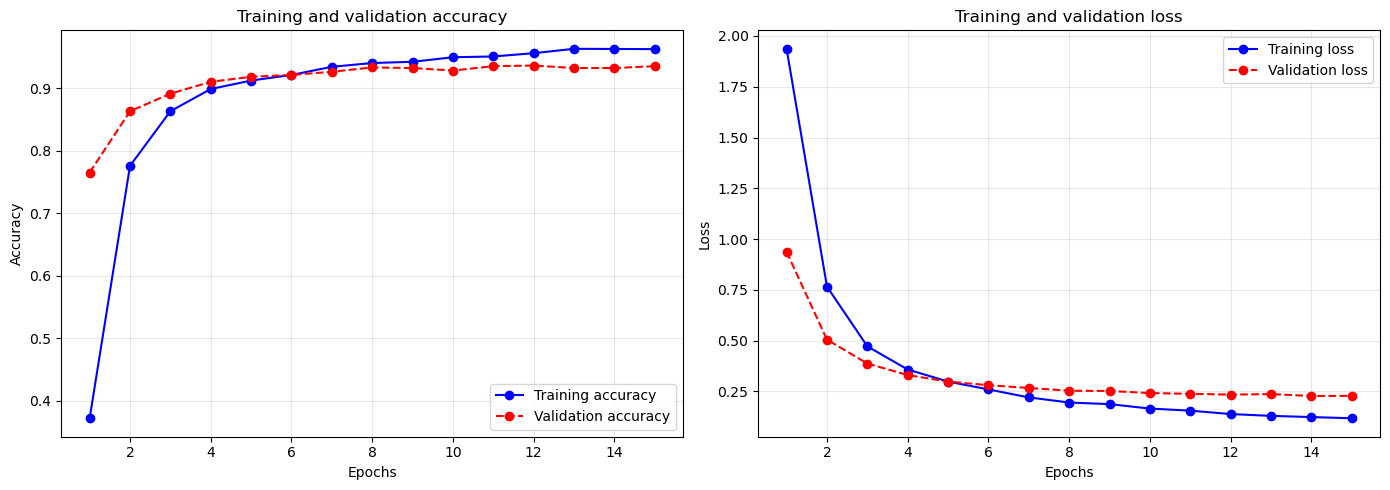

In [29]:
def crear_modelo_mejorado(tamano_imagen, num_clases):
    """
    Modelo MobileNetV2 optimizado con feature extraction básico
    """
    # Input
    inputs = keras.Input(shape=tamano_imagen, name="input")
    
    # Preprocesamiento directo (SIN data augmentation)
    x = layers.Lambda(
        lambda t: keras.applications.mobilenet_v2.preprocess_input(t * 255.0),
        name="preproc"
    )(inputs)
    
    # Base MobileNetV2
    base = keras.applications.MobileNetV2(
        input_shape=tamano_imagen,
        include_top=False,
        weights="imagenet",
        pooling=None
    )
    base.trainable = False
    
    # Feature extraction
    x = base(x, training=False)
    
    # Classifier head mejorado
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)  # Aumentado de 0.2 a 0.3
    outputs = layers.Dense(num_clases, activation="softmax")(x)
    
    # Crear modelo
    modelo = models.Model(inputs, outputs, name="mobilenetv2_mejorado")
    
    # Compilar
    modelo.compile(
        optimizer=keras.optimizers.Adam(5e-4),  # Learning rate más bajo
        loss="categorical_crossentropy",
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name='f1_score', average='macro')
        ]
    )
    
    return modelo


# Uso:
modelo_mejorado = crear_modelo_mejorado(tamano_imagen, num_clases)
modelo_mejorado.summary()

# Entrenar
hist_mejorado, loss_mejorado, acc_mejorado, prec_mejorado, rec_mejorado, f1_mejorado = entrenar(
    modelo_mejorado,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets)
)

# Visualizar
plot(hist_mejorado)

Model: "efficientnetb0_mejorado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_to_255 (Lambda)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.2210 - f1_score: 0.2158 - loss: 2.1829 - precision: 0.5231 - recall: 0.0036 - val_accuracy: 0.6890 - val_f1_score: 0.6841 - val_loss: 1.4520 - val_precision: 0.9434 - val_recall: 0.0500
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.6865 - f1_score: 0.6739 - loss: 1.3044 - precision: 0.9685 - recall: 0.1564 - val_accuracy: 0.8060 - val_f1_score: 0.8067 - val_loss: 0.9607 - val_precision: 0.9757 - val_recall: 0.4420
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.8228 - f1_score: 0.8190 - loss: 0.8700 - precision: 0.9544 - recall: 0.4929 - val_accuracy: 0.8480 - val_f1_score: 0.8499 - val_loss: 0.7292 - val_precision: 0.9620 - val_recall: 0.6080
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.8643 - f1_score: 0.8619 - loss: 0.6622 - precision: 0.9574 - recall: 0.6432 - val_accuracy: 0.8620 - val_f1_score: 0.8641 - val_loss: 0.6059 - val_precision: 0.9517 - val_recall

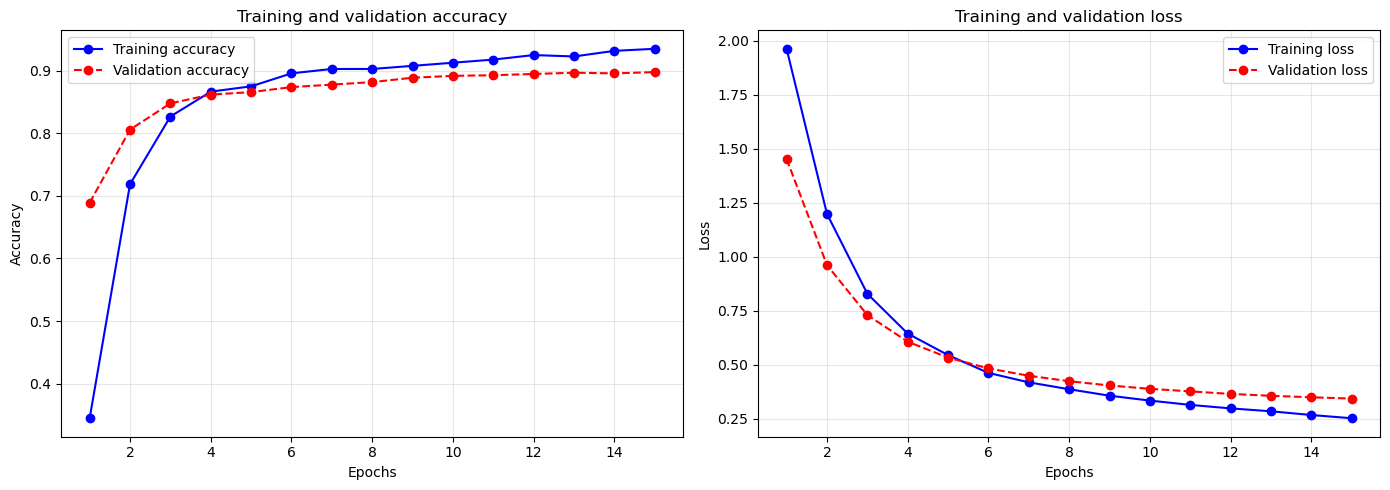

In [33]:
def crear_modelo_efficientnet(tamano_imagen, num_clases):
    """
    Modelo EfficientNetB0 optimizado con feature extraction básico
    """
    # Input
    inputs = keras.Input(shape=tamano_imagen, name="input")
    
    # EfficientNet ya incluye preprocesamiento interno (Rescaling layer)
    # NO necesitas preprocess_input, solo pasar las imágenes [0-255]
    x = layers.Lambda(lambda t: t * 255.0, name="scale_to_255")(inputs)
    
    # Base EfficientNetB0
    base = keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=tamano_imagen,
        pooling=None
    )
    base.trainable = False
    
    # Feature extraction
    x = base(x, training=False)
    
    # Classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_clases, activation="softmax")(x)
    
    # Crear modelo
    modelo = models.Model(inputs, outputs, name="efficientnetb0_mejorado")
    
    # Compilar
    modelo.compile(
        optimizer=keras.optimizers.Adam(5e-4),
        loss="categorical_crossentropy",
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name='f1_score', average='macro')
        ]
    )
    
    return modelo


# Uso:
modelo_efficientnet = crear_modelo_efficientnet(tamano_imagen, num_clases)
modelo_efficientnet.summary()

# Entrenar
hist_efficientnet, loss_efficientnet, acc_efficientnet, prec_efficientnet, rec_efficientnet, f1_efficientnet = entrenar(
    modelo_efficientnet,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets)
)

# Visualizar
plot(hist_efficientnet)